In [2]:
%matplotlib inline

In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map, crop_img

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
def make_cmap(c):
    #cmap = np.asarray(sns.cubehelix_palette(c-1, start=.5, rot=-.75, reverse=True))
    #cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    cmap = np.asarray(sns.color_palette('Reds', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [6]:
mesh_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d_sulc.npy'
mask_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/rh_fullmask.npy'
#data_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/rh_smooth_3_embed_10.npy'
data_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/t1avg/rh_smooth_3_t1avg_embedding_10_cauchy.npy'
#dict_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/rh_smooth_3_embed_10_dict.pkl'

In [7]:
data=np.load(data_file)
sulc=np.load(sulc_file)
mask=np.load(mask_file)
v, f, d = read_vtk(mesh_file)

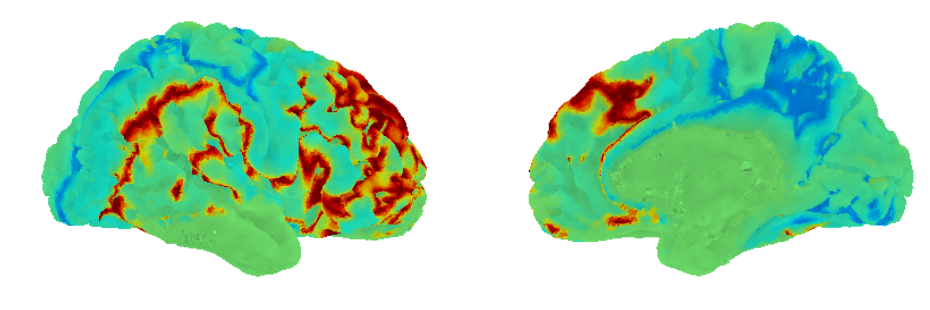

In [9]:
sns.set_style('white')
lat=plot_surf_stat_map(v, f, stat_map=data[:,0], bg_map=sulc, bg_on_stat=True, darkness=0.5, 
                    elev=180,azim=0, figsize=(11,10), cmap='jet' )#,threshold=1700, vmin=1700, vmax=2300)

sns.set_style('white')
med=plot_surf_stat_map(v, f, stat_map=data[:,0], bg_map=sulc, bg_on_stat=True,darkness=0.5,
        elev=180,azim=180, figsize=(11,10),  cmap='jet')#, threshold=1700, vmin=1700, vmax=2300)
    
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
#ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
#ax2 = plt.subplot2grid((4,60), (0,28), colspan = 26, rowspan =4)
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

#fig.savefig(fig_file % (method, hemi, str(e+1)))
#plt.close(fig)

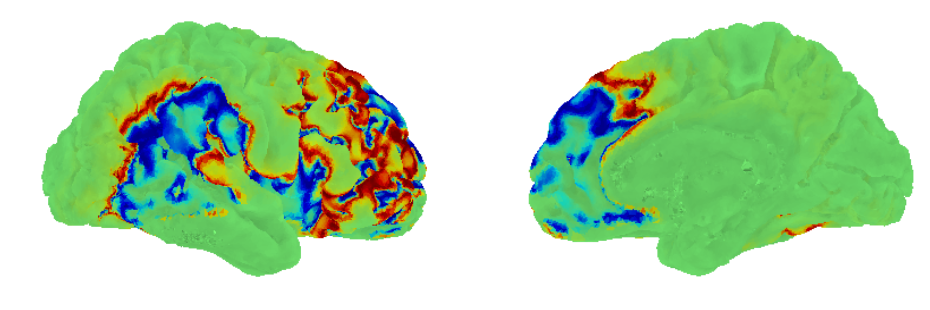

In [10]:
sns.set_style('white')
lat=plot_surf_stat_map(v, f, stat_map=data[:,1], bg_map=sulc, bg_on_stat=True, darkness=0.5, 
                    elev=180,azim=0, figsize=(11,10), cmap='jet' )#,threshold=1700, vmin=1700, vmax=2300)

sns.set_style('white')
med=plot_surf_stat_map(v, f, stat_map=data[:,1], bg_map=sulc, bg_on_stat=True,darkness=0.5,
        elev=180,azim=180, figsize=(11,10),  cmap='jet')#, threshold=1700, vmin=1700, vmax=2300)
    
        
lat_crop=crop_img(lat)
med_crop=crop_img(med)

fig=plt.figure()
fig.set_size_inches(16, 8)
#ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
ax1 = fig.add_subplot(121)
plt.imshow(lat_crop)
ax1.set_axis_off()
#ax2 = plt.subplot2grid((4,60), (0,28), colspan = 26, rowspan =4)
ax2 = fig.add_subplot(122)
plt.imshow(med_crop)
ax2.set_axis_off()

#fig.savefig(fig_file % (method, hemi, str(e+1)))
#plt.close(fig)

In [9]:
fig.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/t1vsfc_6_7.png')

In [157]:
import pickle
pkl_file = open(dict_file, 'rb')
res = pickle.load(pkl_file)
pkl_file.close()
eigenval=res['lambdas']

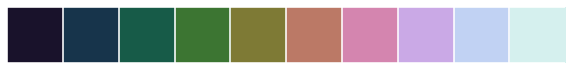

In [158]:
sns.palplot(sns.color_palette('cubehelix',10))

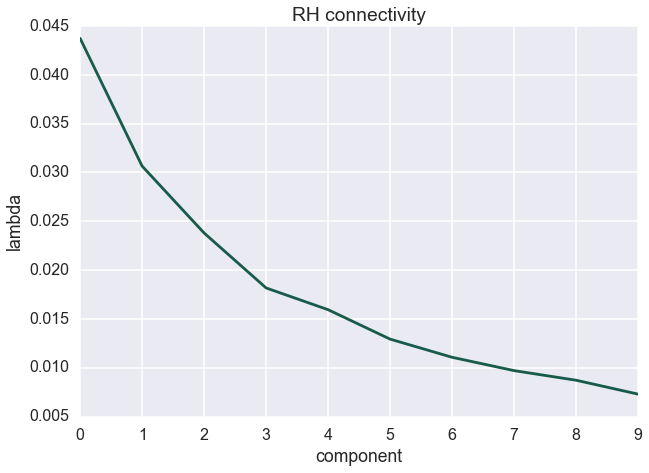

In [159]:
sns.set_context('poster')
sns.set_style('darkgrid')
fig=plt.figure(figsize=(10,7))
plt.plot(eigenval, color=sns.color_palette('cubehelix', 10)[2])
plt.ylabel('lambda')
plt.xlabel('component')
plt.title('RH connectivity')
fig.savefig('/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/figs/connectivity_rh_lambda.png')

ERROR! Session/line number was not unique in database. History logging moved to new session 1790


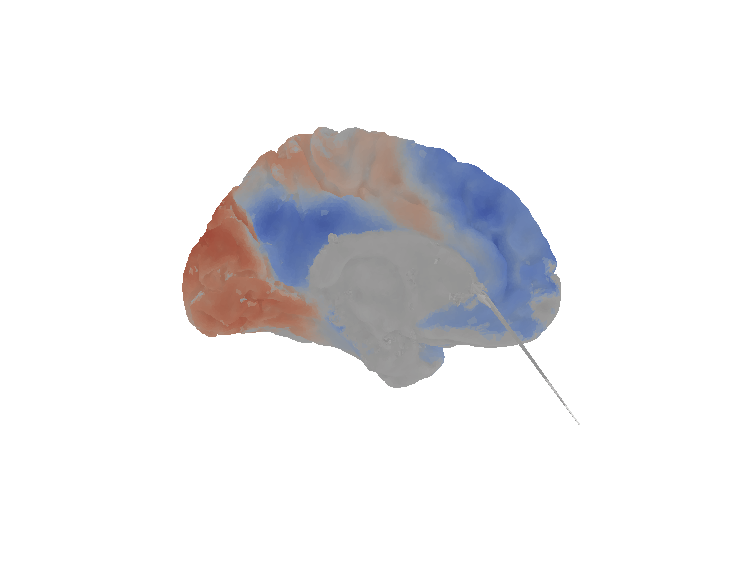

In [65]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,0], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=0, figsize=(11,10), darkness=0.2)

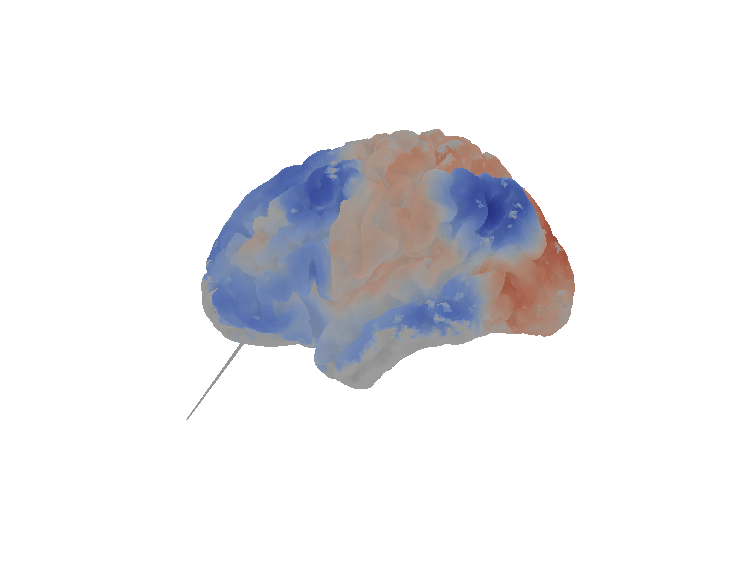

In [68]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,0], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=180, figsize=(11,10), darkness=0.2)

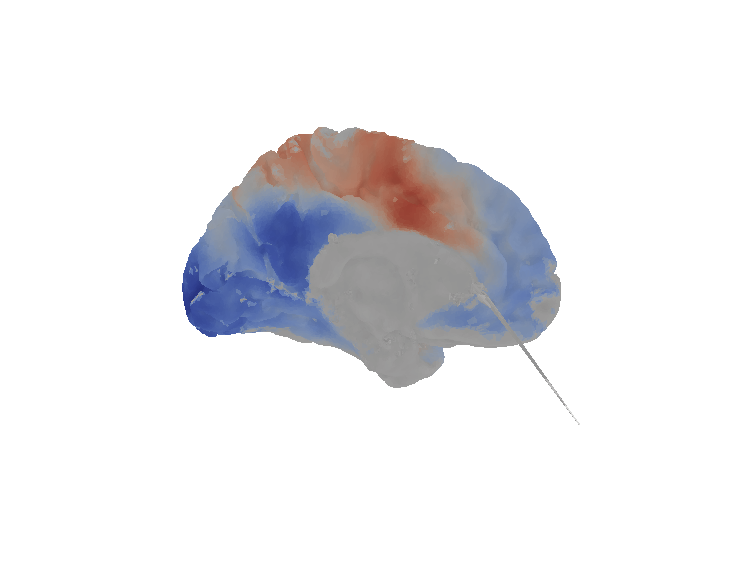

In [69]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,1], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=0, figsize=(11,10), darkness=0.2)

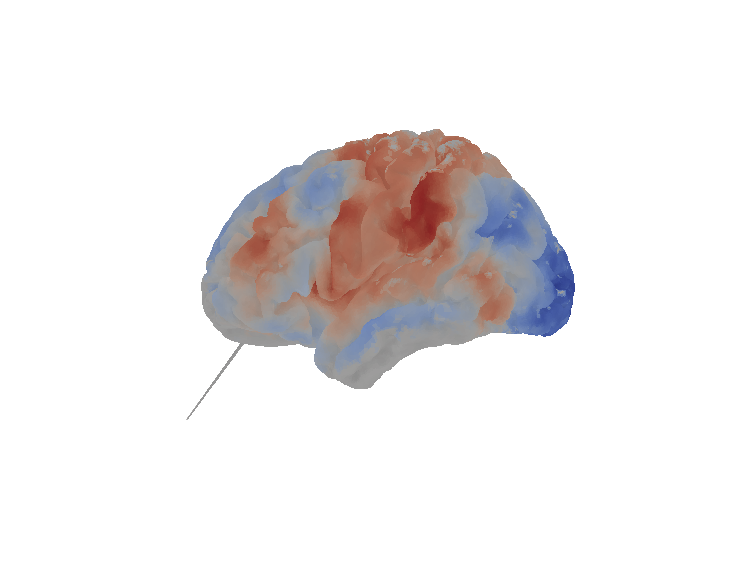

In [70]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,1], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=180, figsize=(11,10), darkness=0.2)

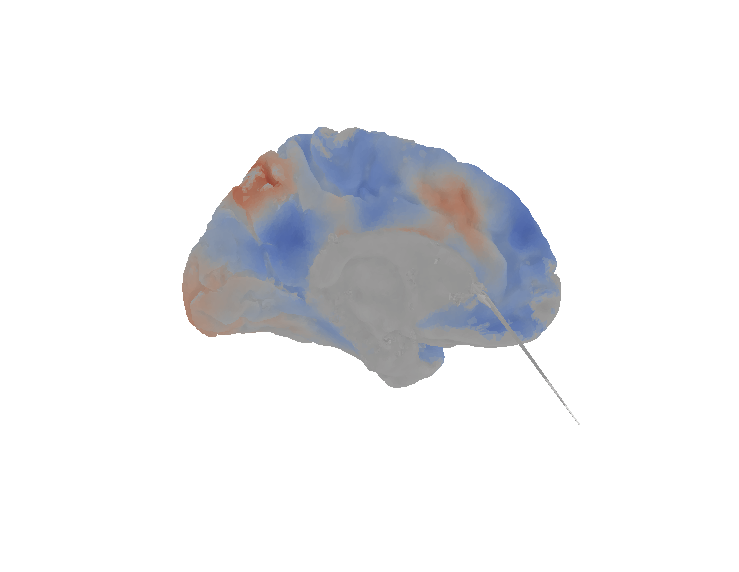

In [71]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,2], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=0, figsize=(11,10), darkness=0.2)

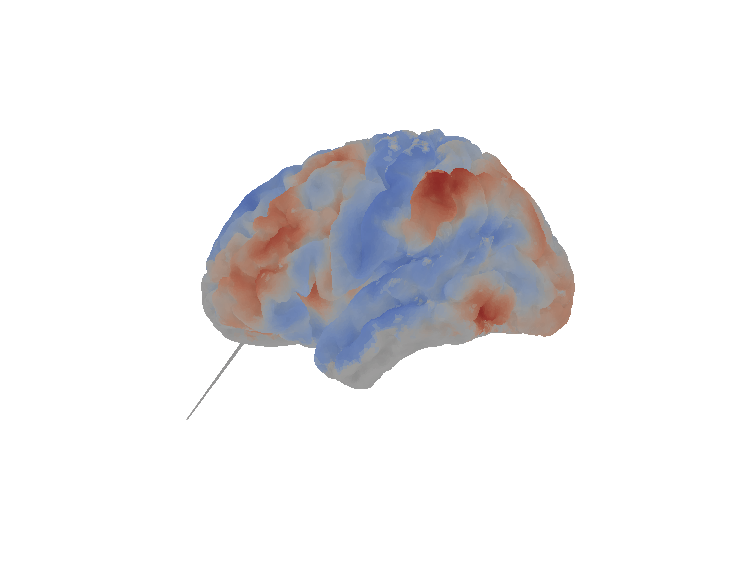

In [72]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,2], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=180, figsize=(11,10), darkness=0.2)

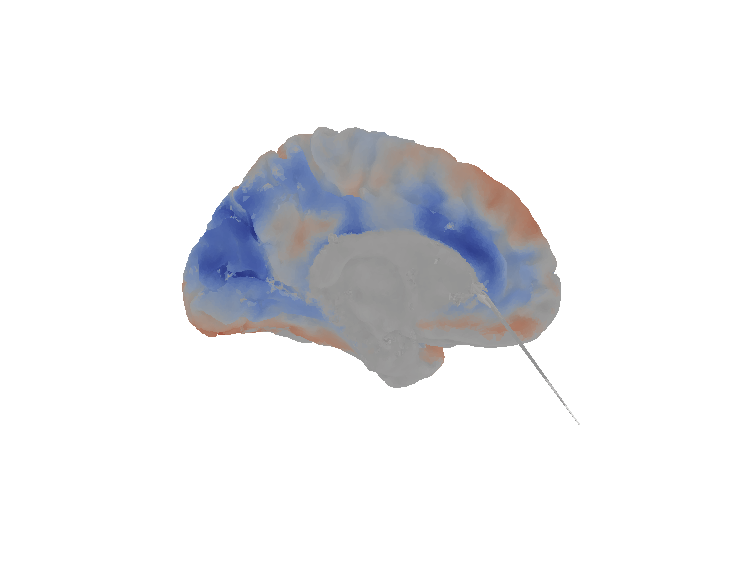

In [73]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,3], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=0, figsize=(11,10), darkness=0.2)

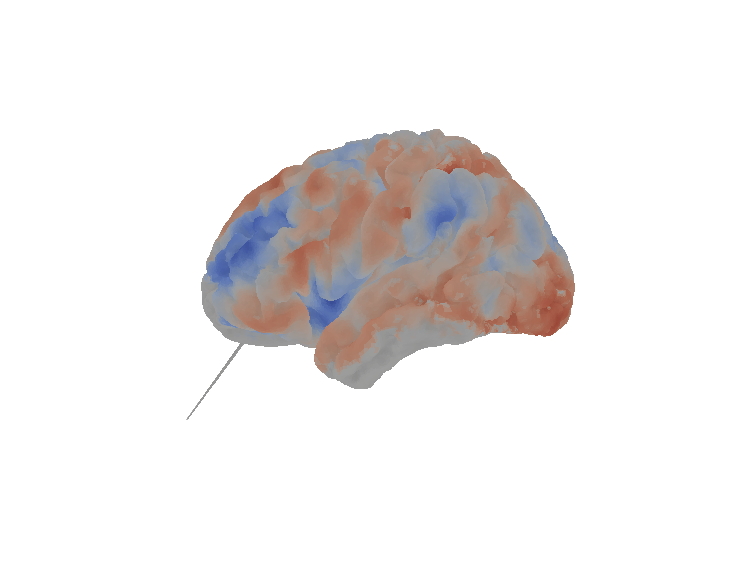

In [74]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,3], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=180, figsize=(11,10), darkness=0.2)

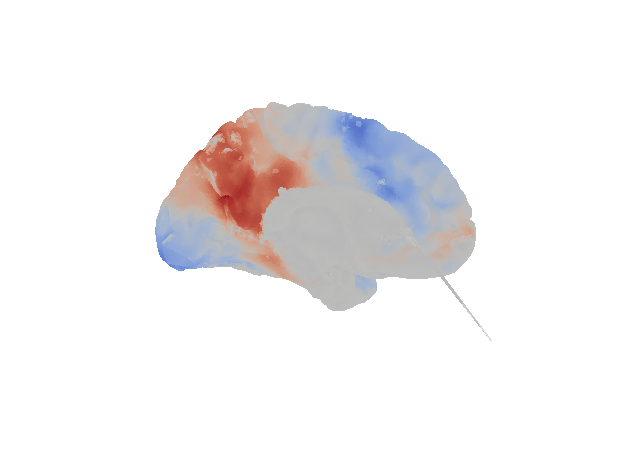

In [89]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,4], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=0, figsize=(13,10), darkness=0.2)

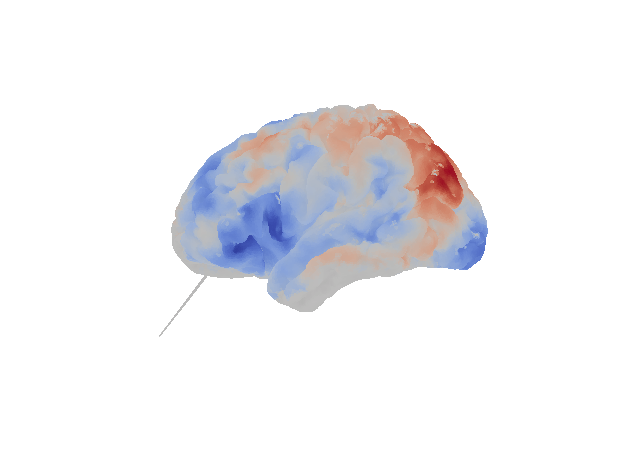

In [78]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, stat_map=data[:,4], bg_map=sulc, bg_on_stat=True,
                        elev=180,azim=180, figsize=(11,10), darkness=0.2)

In [81]:
from plotting import crop_img

In [88]:
img1=crop_img(plot)

In [90]:
img2=crop_img(plot)

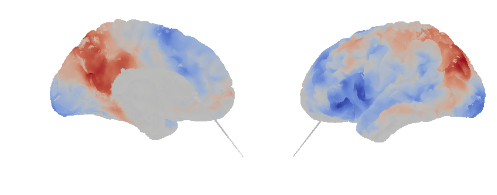

In [98]:
fig=plt.figure()
fig.set_size_inches(8, 4)
ax1 = fig.add_subplot(121)
plt.imshow(img2)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
plt.imshow(img1)
ax2.set_axis_off()


In [93]:
fig.savefig('/tmp/test.png')

In [ ]:
sns.set_context('poster')
sns.set_style('darkgrid')
fig=plt.figure(figsize=(20,30))
for comp in range(10):
    fig.add_subplot(5,2,comp+1)
    plt.hist(data_masked[:,comp], bins=50, color=sns.color_palette('cubehelix',20)[comp], alpha=0.8);
    plt.xlabel('Component %s'%str(comp+1))
fig.suptitle('Profile embedding 3_7 masked', fontsize=30)
#plt.xticks(np.arange(0, max(data_masked)+1, 1000))
#plt.xlim(min(data_masked), max(data_masked))

#fig.add_subplot(212)
#plt.hist(data_norm, bins=30, color=sns.color_palette('cubehelix',10)[5], alpha=0.8);
#plt.xticks(np.arange(-2, +3, 0.2))
#plt.xlim(min(data_norm), max(data_norm))
#plt.xlabel('normalized row sum')
fig.savefig('/scr/ilz3/myelinconnect/pics/profile_embedding_37_hist.png')

In [ ]:
sns.set_context('poster')
sns.set_style('white')
plot = plot_surf_stat_map(v, f, stat_map=data[:,9], threshold=0.000000001, bg_map=sulc, elev=180, azim=180, figsize=(11,10))

In [ ]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.imshow(gradient, aspect='auto', cmap=cbar)
plt.axis('off')

In [ ]:
x=v[:,0]
y=v[:,1]
z=v[:,2]
triangles=f
pal, pal_255 = make_cmap(10)

In [ ]:
sns.palplot(pal)

In [ ]:
data_thr=data[:,0]
data_thr[mask]=0
data_thr[np.where(data_masked[:,0]<-0.1)]=-0.1

In [ ]:
np.where(data_masked[:,0]<-0.1)[0].shape

In [ ]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=data_thr, colormap='RdBu')
#lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
#img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

In [ ]:
data[:,0].shape